In [13]:
import sys
print(sys.executable)
%pip install -U numpy matplotlib

/home/codespace/.python/current/bin/python
Note: you may need to restart the kernel to use updated packages.


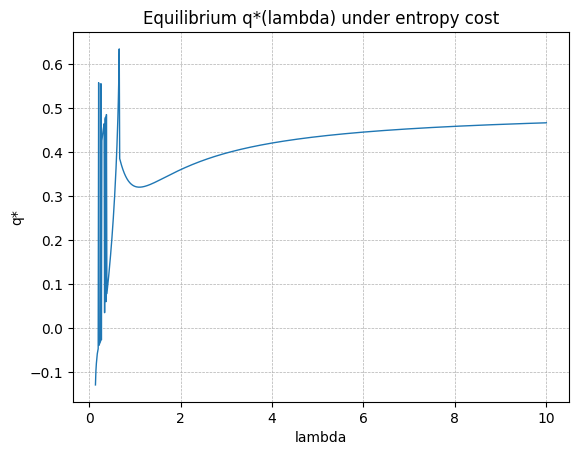

lambda, q* (first 5):
0.10, nan
0.11, nan
0.12, nan
0.13, nan
0.14, -0.128917
lambda, q* (last 5):
9.96, 0.466613
9.97, 0.466646
9.98, 0.466679
9.99, 0.466711
10.00, 0.466744


In [1]:
"""
Solve the 8-equation equilibrium for {q*, qbar, qunder, alpha, p, V_B, V_L, sigma_s}
as a function of lambda, under entropy cost K(q) = -q ln q - (1-q) ln(1-q) (natural logs).

USER API (6 inputs):
    v_h, v_l, c_h, c_l, delta, qhat

TASK:
  - For fixed (v_h, v_l, c_h, c_l, delta, qhat),
    iterate lambdas from 0.10 to 10.00 in steps of 0.01 (regular scale),
    solve q*(lambda) for each lambda,
    and plot q* vs lambda on a REGULAR x-axis (not log).

Requires: numpy, matplotlib
"""

import math
import numpy as np
import matplotlib.pyplot as plt


# -------------------------
# Entropy cost (natural logs)
# -------------------------
def _clip01(q, eps=1e-14):
    return min(max(float(q), eps), 1.0 - eps)

def K_entropy(q):
    q = _clip01(q)
    return -q * math.log(q) - (1.0 - q) * math.log(1.0 - q)

def k_entropy(q):
    q = _clip01(q)
    return math.log((1.0 - q) / q)


# -------------------------
# Core equilibrium solver for one lambda
# -------------------------
def solve_equilibrium_for_lambda(
    lam: float,
    v_h: float,
    v_l: float,
    c_h: float,
    c_l: float,
    qhat: float,
    delta: float,
    # numerical controls (usually you won't touch these)
    t_min: float = -80.0,
    t_max: float =  80.0,
    scan_points: int = 8001,
    bisect_tol: float = 1e-12,
    bisect_maxiter: int = 300,
    prefer_high_qbar: bool = True,
    prev_t_star: float | None = None,
):
    """
    Solves (1)-(7) by reducing to a single root in qbar through eq (4),
    then recovers sigma_s from eq (8) (M cancels).

    Returns a dict with solution. If no sign-change bracket found, returns best-effort minimizer.
    """
    lam = float(lam)
    if lam <= 0:
        raise ValueError("lambda must be > 0.")
    qhat = float(qhat)
    if not (0.0 < qhat < 1.0):
        raise ValueError("qhat must be in (0,1).")
    delta = float(delta)
    if not (0.0 < delta < 1.0):
        raise ValueError("delta must be in (0,1).")

    dv = v_h - v_l

    def sigmoid(t: float) -> float:
        if t >= 0:
            z = math.exp(-t)
            return 1.0 / (1.0 + z)
        else:
            z = math.exp(t)
            return z / (1.0 + z)

    def underline_q(qbar: float) -> float:
        # (2): lam k(qunder) = dv + lam k(qbar)
        # => qunder = qbar / (qbar + (1-qbar)*exp(dv/lam))
        E = math.exp(dv / lam)
        return qbar / (qbar + (1.0 - qbar) * E)

    def V_B_from_concav(qbar: float, qunder: float) -> float:
        # From (3):
        # V_B = (v_l - c_h) + dv*qbar + lam[ K(qbar)-K(qunder) - (qbar-qunder)k(qunder) ]
        return (v_l - c_h) + dv * qbar + lam * (
            K_entropy(qbar) - K_entropy(qunder) - (qbar - qunder) * k_entropy(qunder)
        )

    def beta_from_VB(VB: float) -> float:
        # (5) and (7): p = V_L + c_l and V_B = v_l - p => V_L = v_l - c_l - V_B
        VL = (v_l - c_l) - VB

        # (6): V_L = delta[ beta*(c_h-c_l) + (1-beta)*V_L ]
        # => beta = V_L*(1-delta) / (delta*((c_h-c_l) - V_L))
        Dc = (c_h - c_l)
        denom = delta * (Dc - VL)
        if abs(denom) < 1e-14:
            return float("nan")
        return VL * (1.0 - delta) / denom

    def qstar_from(qbar: float, qunder: float, beta: float) -> float:
        # From (1) + beta definition:
        # q* = ((1-qbar)*qunder + beta*(qbar-qunder)) / ((1-qbar)+beta*(qbar-qunder))
        num = (1.0 - qbar) * qunder + beta * (qbar - qunder)
        den = (1.0 - qbar) + beta * (qbar - qunder)
        if abs(den) < 1e-16:
            return float("nan")
        return num / den

    def alpha_from(qbar: float, qunder: float, qstar: float) -> float:
        den = (qbar - qunder)
        if abs(den) < 1e-16:
            return float("nan")
        return (qstar - qunder) / den

    def residual_in_qbar(qbar: float) -> float:
        qbar = _clip01(qbar)
        qunder = _clip01(underline_q(qbar))
        VB = V_B_from_concav(qbar, qunder)

        beta = beta_from_VB(VB)
        if not math.isfinite(beta):
            return float("nan")

        qstar = qstar_from(qbar, qunder, beta)
        if not (math.isfinite(qstar) and 0.0 < qstar < 1.0):
            return float("nan")

        alpha = alpha_from(qbar, qunder, qstar)
        if not math.isfinite(alpha):
            return float("nan")

        flow_high_action = qbar * v_h + (1.0 - qbar) * v_l - c_h
        info_gap = K_entropy(qstar) - alpha * K_entropy(qbar) - (1.0 - alpha) * K_entropy(qunder)

        RHS = delta * (
            alpha * flow_high_action
            + (1.0 - alpha) * VB
            - lam * info_gap
        )
        return VB - RHS

    def G(t: float) -> float:
        return residual_in_qbar(sigmoid(t))

    # --- bracketing ---
    def find_brackets_by_scan(t_lo: float, t_hi: float, npts: int):
        t_grid = np.linspace(t_lo, t_hi, npts)
        G_vals = np.array([G(t) for t in t_grid], dtype=float)
        finite = np.isfinite(G_vals)
        t_f = t_grid[finite]
        g_f = G_vals[finite]
        if len(g_f) < 2:
            return [], None, None

        s = np.sign(g_f)
        s[s == 0.0] = 1.0
        brackets = []
        for i in range(len(g_f) - 1):
            if s[i] * s[i + 1] < 0:
                brackets.append((float(t_f[i]), float(t_f[i + 1])))

        j = int(np.nanargmin(np.abs(g_f)))
        return brackets, float(t_f[j]), float(g_f[j])

    brackets, t_best, g_best = find_brackets_by_scan(t_min, t_max, scan_points)

    if not brackets:
        for mult in [2.0, 4.0, 8.0]:
            lo, hi = t_min * mult, t_max * mult
            brackets, t_best, g_best = find_brackets_by_scan(lo, hi, scan_points)
            if brackets:
                t_min, t_max = lo, hi
                break

    a = b = fa = fb = None
    if not brackets:
        if t_best is None or not math.isfinite(g_best):
            raise RuntimeError("Residual not finite anywhere on scan; cannot solve this lambda.")

        h = 0.25
        g0 = G(t_best)
        for _ in range(60):
            tL, tR = t_best - h, t_best + h
            gL, gR = G(tL), G(tR)

            if math.isfinite(gL) and math.isfinite(gR) and gL * gR < 0:
                a, b, fa, fb = tL, tR, gL, gR
                break
            if math.isfinite(g0) and math.isfinite(gL) and g0 * gL < 0:
                a, b, fa, fb = tL, t_best, gL, g0
                break
            if math.isfinite(g0) and math.isfinite(gR) and g0 * gR < 0:
                a, b, fa, fb = t_best, tR, g0, gR
                break

            h *= 2.0

        if a is None:
            # Best-effort minimizer: return the scan minimizer instead of crashing
            qbar_best = sigmoid(t_best)
            qunder_best = underline_q(qbar_best)
            VB_best = V_B_from_concav(qbar_best, qunder_best)
            beta_best = beta_from_VB(VB_best)
            qstar_best = qstar_from(qbar_best, qunder_best, beta_best)
            alpha_best = alpha_from(qbar_best, qunder_best, qstar_best)

            p_best = v_l - VB_best
            VL_best = p_best - c_l

            ratio = qhat / (1.0 - qhat)
            denom = (1.0 - qstar_best) * ratio
            if abs(denom) < 1e-16 or abs(1.0 - beta_best) < 1e-12:
                sigma_s_best = float("nan")
            else:
                target = (qbar_best * alpha_best) / denom
                sigma_s_best = (target - beta_best) / (1.0 - beta_best)
                sigma_s_best = min(max(sigma_s_best, 0.0), 1.0)

            return {
                "lambda": lam,
                "q_star": qstar_best,
                "q_bar": qbar_best,
                "q_under": qunder_best,
                "alpha": alpha_best,
                "p": p_best,
                "V_B": VB_best,
                "V_L": VL_best,
                "beta": beta_best,
                "sigma_s": sigma_s_best,
                "t_star": t_best,
                "residual": residual_in_qbar(qbar_best),
                "note": "No sign-change bracket found; returned best-effort minimizer."
            }

    else:
        if prev_t_star is not None:
            brackets.sort(key=lambda ab: abs(0.5 * (ab[0] + ab[1]) - prev_t_star))
            a, b = brackets[0]
        else:
            if prefer_high_qbar:
                a, b = max(brackets, key=lambda ab: 0.5 * (ab[0] + ab[1]))
            else:
                a, b = brackets[0]

        fa, fb = G(a), G(b)
        if not (math.isfinite(fa) and math.isfinite(fb) and fa * fb < 0):
            # fallback to best-effort at midpoint
            t_mid = 0.5 * (a + b)
            qbar_best = sigmoid(t_mid)
            qunder_best = underline_q(qbar_best)
            VB_best = V_B_from_concav(qbar_best, qunder_best)
            beta_best = beta_from_VB(VB_best)
            qstar_best = qstar_from(qbar_best, qunder_best, beta_best)
            alpha_best = alpha_from(qbar_best, qunder_best, qstar_best)

            p_best = v_l - VB_best
            VL_best = p_best - c_l

            ratio = qhat / (1.0 - qhat)
            denom = (1.0 - qstar_best) * ratio
            if abs(denom) < 1e-16 or abs(1.0 - beta_best) < 1e-12:
                sigma_s_best = float("nan")
            else:
                target = (qbar_best * alpha_best) / denom
                sigma_s_best = (target - beta_best) / (1.0 - beta_best)
                sigma_s_best = min(max(sigma_s_best, 0.0), 1.0)

            return {
                "lambda": lam,
                "q_star": qstar_best,
                "q_bar": qbar_best,
                "q_under": qunder_best,
                "alpha": alpha_best,
                "p": p_best,
                "V_B": VB_best,
                "V_L": VL_best,
                "beta": beta_best,
                "sigma_s": sigma_s_best,
                "t_star": t_mid,
                "residual": residual_in_qbar(qbar_best),
                "note": "Bracket invalid after selection; returned best-effort minimizer."
            }

    # --- bisection ---
    for _ in range(bisect_maxiter):
        m = 0.5 * (a + b)
        fm = G(m)
        if not math.isfinite(fm):
            m = math.nextafter(m, a)
            fm = G(m)

        if abs(fm) < 1e-14 or (b - a) < bisect_tol:
            t_star = m
            break

        if fa * fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    else:
        t_star = 0.5 * (a + b)

    # Reconstruct equilibrium objects
    qbar = sigmoid(t_star)
    qunder = underline_q(qbar)
    VB = V_B_from_concav(qbar, qunder)
    beta = beta_from_VB(VB)
    qstar = qstar_from(qbar, qunder, beta)
    alpha = alpha_from(qbar, qunder, qstar)

    p = v_l - VB
    VL = p - c_l

    # sigma_s from (8); M cancels
    ratio = qhat / (1.0 - qhat)
    denom = (1.0 - qstar) * ratio
    if abs(denom) < 1e-16 or abs(1.0 - beta) < 1e-12:
        sigma_s = float("nan")
    else:
        target = (qbar * alpha) / denom
        sigma_s = (target - beta) / (1.0 - beta)
        sigma_s = min(max(sigma_s, 0.0), 1.0)

    return {
        "lambda": lam,
        "q_star": qstar,
        "q_bar": qbar,
        "q_under": qunder,
        "alpha": alpha,
        "p": p,
        "V_B": VB,
        "V_L": VL,
        "beta": beta,
        "sigma_s": sigma_s,
        "t_star": t_star,
        "residual": residual_in_qbar(qbar),
        "note": ""
    }


# -------------------------
# Main routine: iterate lambdas and plot q*(lambda)
# -------------------------
def qstar_vs_lambda_plot(
    v_h: float,
    v_l: float,
    c_h: float,
    c_l: float,
    delta: float,
    qhat: float,
    lam_start: float = 0.10,
    lam_end: float = 10.00,
    lam_step: float = 0.01,
):
    """
    Given the 6 inputs, compute q*(lambda) on a regular lambda grid and plot on regular scale.
    Returns (lambdas, qstars, sols).
    """
    # regular grid, inclusive end (within floating tolerance)
    n = int(round((lam_end - lam_start) / lam_step)) + 1
    lambdas = lam_start + lam_step * np.arange(n)
    qstars = np.full_like(lambdas, np.nan, dtype=float)
    sols = []

    prev_t = None
    for i, lam in enumerate(lambdas):
        sol = solve_equilibrium_for_lambda(
            lam=lam,
            v_h=v_h, v_l=v_l, c_h=c_h, c_l=c_l,
            qhat=qhat, delta=delta,
            prev_t_star=prev_t,      # continuation
            prefer_high_qbar=True,   # choose high-qbar root if multiple
            t_min=-80.0, t_max=80.0, scan_points=8001
        )
        prev_t = sol.get("t_star", None)
        qstars[i] = sol["q_star"]
        sols.append(sol)

    plt.figure()
    plt.plot(lambdas, qstars, linewidth=1)
    plt.xlabel("lambda")
    plt.ylabel("q*")
    plt.title("Equilibrium q*(lambda) under entropy cost")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()

    return lambdas, qstars, sols


# -------------------------
# Example usage (edit the 6 inputs here)
# -------------------------
if __name__ == "__main__":
    # 6 exogenous inputs
    v_h = 4.0
    v_l = 1.0
    c_h = 2.5
    c_l = 0.0
    delta = 0.95
    qhat = 0.4

    lambdas, qstars, sols = qstar_vs_lambda_plot(
        v_h=v_h, v_l=v_l, c_h=c_h, c_l=c_l, delta=delta, qhat=qhat,
        lam_start=0.10, lam_end=10.00, lam_step=0.01
    )

    # Print a couple of points
    print("lambda, q* (first 5):")
    for i in range(5):
        print(f"{lambdas[i]:.2f}, {qstars[i]:.6f}")

    print("lambda, q* (last 5):")
    for i in range(-5, 0):
        print(f"{lambdas[i]:.2f}, {qstars[i]:.6f}")


        
